In [25]:
import lz4.frame
import pickle
import os
import pdb
import hist

from utilities.io_tools import input_tools, output_tools
from wremnants import plot_tools, theory_corrections, histselections as sel

In [17]:
webdir = "/home/d/dwalter/www/WMassAnalysis/240307_ewISR/"

t_axis = {
    "ptVgen": r"Pre FSR $p_\mathrm{T}^{\ell\ell}$",
    "massVgen": r"Pre FSR $m^{\ell\ell}$",
    "absYVgen": r"Pre FSR $|Y^{\ell\ell}|$",
}
t_label_num = {
    "pythiaew_ISR": "pythia QED ISR on", 
    "winhacloew": "winhac FSR", 
    "horaceqedew": "horace FSR", 
    "horacelophotosmecoffew": "photos(MEC off) FSR", 
    "MiNNLOew_ISR": "QED ISR",
    "MiNNLOew_v2": "QED ISR",
    "MiNNLOnoqedisrew_ISR": "pythia no QED ISR", 
}
t_label_den = {
    "pythiaew_ISR": "pythia QED ISR off", 
    "winhacloew": "photos FSR", 
    "horaceqedew": "photos FSR", 
    "horacelophotosmecoffew": "photos FSR", 
    "MiNNLOew_ISR": "no QED ISR",
    "MiNNLOew_v2": "no QED ISR",
    "MiNNLOnoqedisrew_ISR": "pythia QED ISR", 
}

translate_txt = {
    "Wplus": r"$W^{+}\rightarrow\mu\nu$",
    "Wminus": r"$W^{-}\rightarrow\mu\nu$",
    "Z": r"$Z\rightarrow\mu\mu$",
}

In [18]:
def get_corr(filename):
    with lz4.frame.open(filename) as f:
        corr = pickle.load(f)
        return corr

In [4]:
res, _1, _2 = input_tools.read_infile("/scratch/dwalter/results_histmaker/240307_ewISR/w_z_gen_dists.hdf5")
res.keys()

dict_keys(['ZmumuPostVFP', 'Zmumu_MiNNLO-noqedisr', 'Zmumu_horace-lo-photos', 'Zmumu_horace-lo-photos-isroff', 'Zmumu_horace-lo-photos-mecoff', 'meta_info'])

In [5]:
h1 = input_tools.load_and_scale(res, "Zmumu_MiNNLO-noqedisr", "preFSR_absYVptV", apply_xsec=False)
h2 = input_tools.load_and_scale(res, "ZmumuPostVFP", "preFSR_absYVptV", apply_xsec=False)
print(h1.values(flow=True).sum())
print(h2.values(flow=True).sum())

print(res["Zmumu_MiNNLO-noqedisr"]["dataset"]["xsec"])
print(res["ZmumuPostVFP"]["dataset"]["xsec"])

count1 = res["Zmumu_MiNNLO-noqedisr"]["event_count"]
count2 = res["ZmumuPostVFP"]["event_count"]

print(res["Zmumu_MiNNLO-noqedisr"]["output"]["preFSR_absYVptV"].get().values(flow=True).sum() / count1)
print(res["ZmumuPostVFP"]["output"]["preFSR_absYVptV"].get().values(flow=True).sum() / count2)


246767002.0
78961709.0
2001.9
2001.9
0.8466872893013309
0.8466292474502735


In [19]:
gen="pythia"
hists = get_corr(f"../test/{gen}ew_ISRCorrZ.pkl.lz4")
hists.update(get_corr(f"../test/{gen}ew_ISRCorrW.pkl.lz4"))

# hists["Z"].update(get_corr("../test_231221_ewFSR_fiducial/horacelophotosmecoffewCorrZ.pkl.lz4")["Z"])
# hists["W"].update(get_corr("../test_231221_ewFSR_fiducial/horacelophotosmecoffewCorrW.pkl.lz4")["W"])

print(hists.keys())
print(hists["Z"].keys())
print(hists["W"].keys())
print(hists["Z"]["pythiaew_ISR_num"].axes.name)
print(hists["W"]["pythiaew_ISR_num"].axes.name)

dict_keys(['Z', 'meta_data', 'W'])
dict_keys(['pythiaew_ISR_minnlo_ratio', 'pythiaew_ISR_num', 'pythiaew_ISR_den'])
dict_keys(['pythiaew_ISR_minnlo_ratio', 'pythiaew_ISR_num', 'pythiaew_ISR_den'])
('massVgen', 'ptVgen', 'charge')
('massVgen', 'ptVgen', 'charge')


In [75]:
hists = get_corr("../wremnants-data/data/TheoryCorrections/MiNNLOew_v2CorrZ.pkl.lz4")
hists.update(get_corr("../wremnants-data/data/TheoryCorrections/MiNNLOew_v2CorrW.pkl.lz4"))
hists.keys()
hists["W"].keys()

dict_keys(['MiNNLOew_v2_minnlo_ratio', 'MiNNLOew_v2_num', 'MiNNLOew_v2_den'])

In [28]:
def plot_corr(process, axis, nums, den, selection=None, xlim=[0,100], rrange=None):
    if type(axis)!=list:
        axis = [axis]
    
    if selection:
        h1ds = [
            hists[process][f"{den}_den"][selection].project(*axis), 
            *[hists[process][f"{n}_num"][selection].project(*axis) for n in nums]]
        rrange = [0.9975, 1.0025] if rrange is None else rrange
        if "charge" in selection:
            process = process.replace("W", "Wminus") if selection["charge"] == 0 else process.replace("W", "Wplus")
    else:
        h1ds = [hists[process][f"{den}_den"].project(*axis), *[hists[process][f"{n}_num"].project(*axis) for n in nums]]
        rrange = [0.996, 1.004] if rrange is None else rrange

    h1ds = [h[{"massVgen": hist.rebin(4)}] for h in h1ds]
    
    if len(axis)>1:
        h1ds = [sel.unrolledHist(h1d, binwnorm=1, obs=axis) for h1d in h1ds]

    fig = plot_tools.makePlotWithRatioToRef(
                h1ds,
                [t_label_den.get(den,den), *[t_label_num.get(n, n) for n in nums]],
                colors=["black", *["red", "blue"][:len(nums)]], 
                linestyles=["solid", *["dashed", "dotted"][:len(nums)]],
                xlabel=" ".join([t_axis.get(a, a) for a in axis]), 
                ylabel="Events/bin",
                rlabel=f"x/{t_label_den.get(den,den)}",
                legtext_size=16,
                rrange=rrange,
                yscale=1.0,
                xlim=xlim, binwnorm=1.0, baseline=True, extra_text=translate_txt.get(process, rf"${process}\rightarrow\mu\mu$"))
    
    output_tools.make_plot_dir(webdir, process)
    out = os.path.join(webdir, process)
    plot_tools.save_pdf_and_png(out, f"{den}_{process}_{axis}")
    plot_tools.write_index_and_log(out, f"{den}_{process}_{axis}")

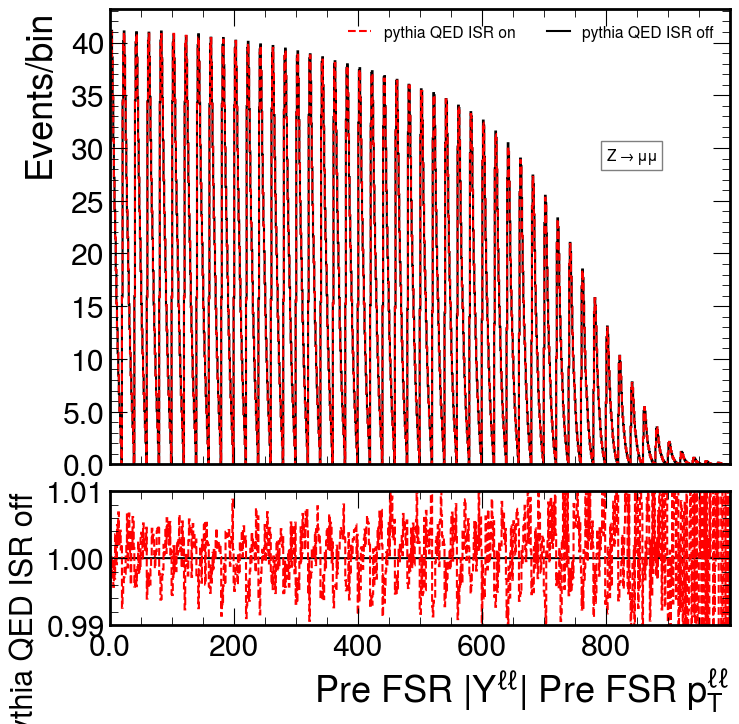

In [8]:
plot_corr("Z", ["absYVgen","ptVgen"], [f"{gen}ew_ISR",], f"{gen}ew_ISR", xlim=[0,2.5], rrange=[0.99,1.01])

In [21]:
plot_corr("Z", "massVgen", [f"{gen}ew_ISR"], f"{gen}ew_ISR", xlim=[60,120], rrange=[0.995,1.005])
# plot_corr("W", "ewMll", ["MiNNLOew_v2"], "MiNNLOew_v2", selection={"charge":0}, xlim=[50,110], rrange=[0.995,1.005])
# plot_corr("W", "ewMll", ["MiNNLOew_v2"], "MiNNLOew_v2", selection={"charge":1}, xlim=[50,110], rrange=[0.995,1.005])

ValueError: The axis name massVgen could not be found

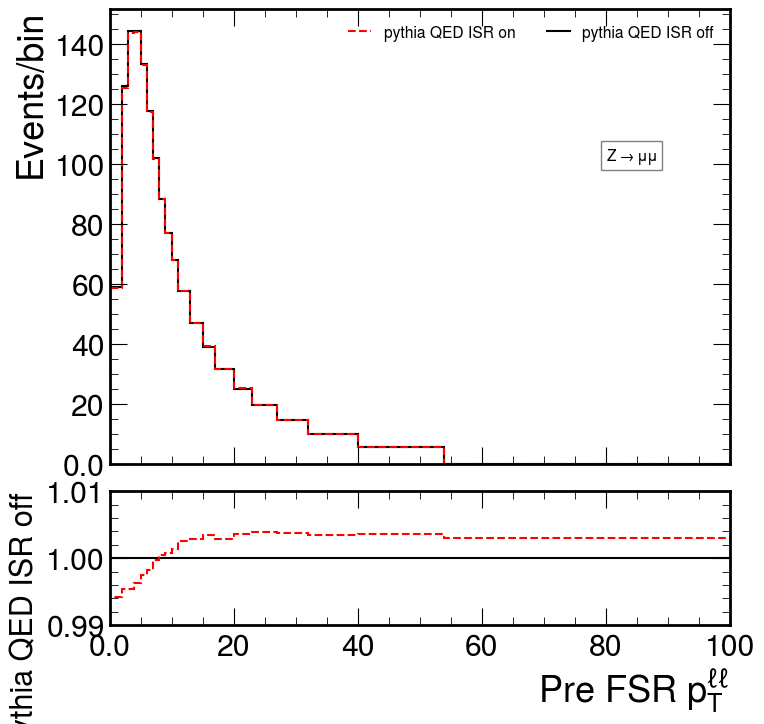

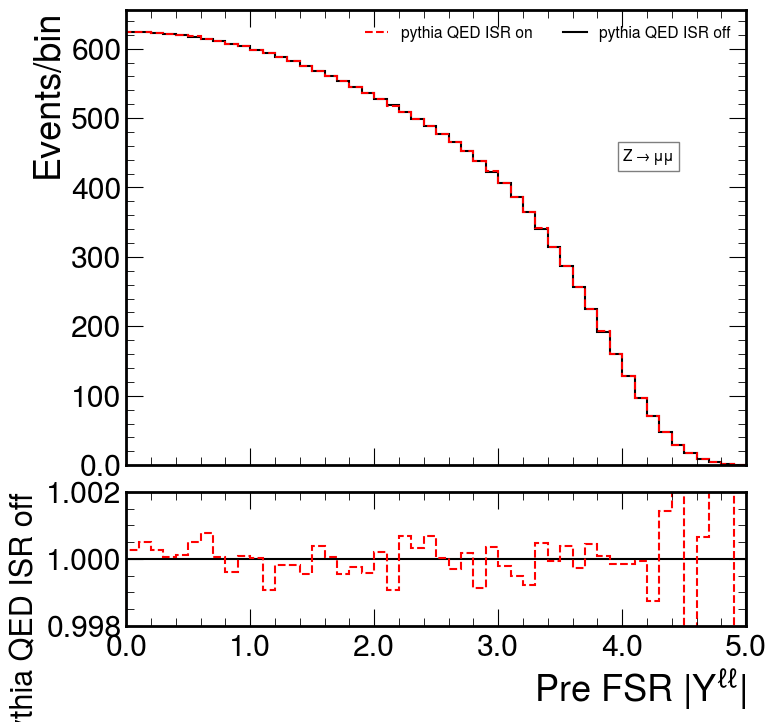

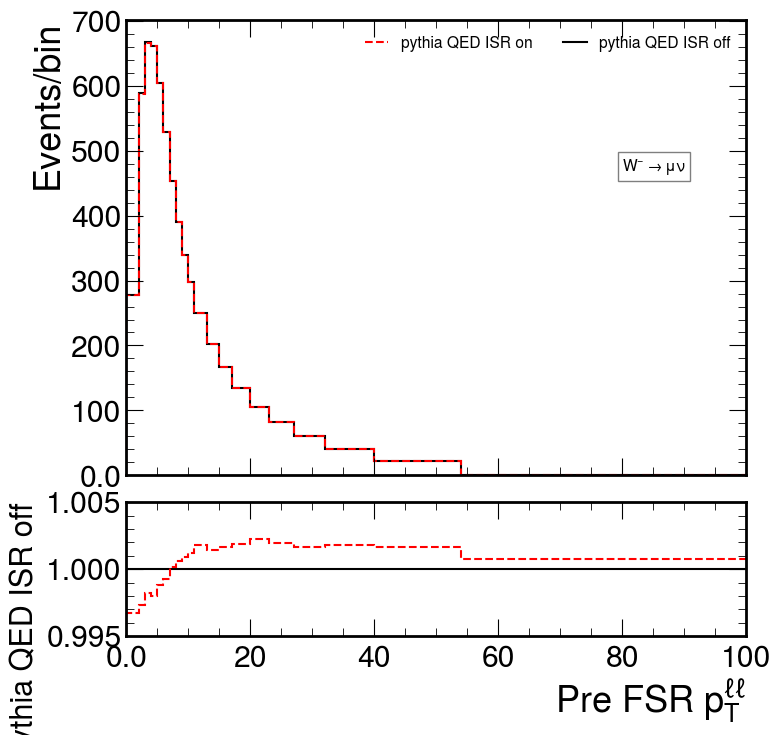

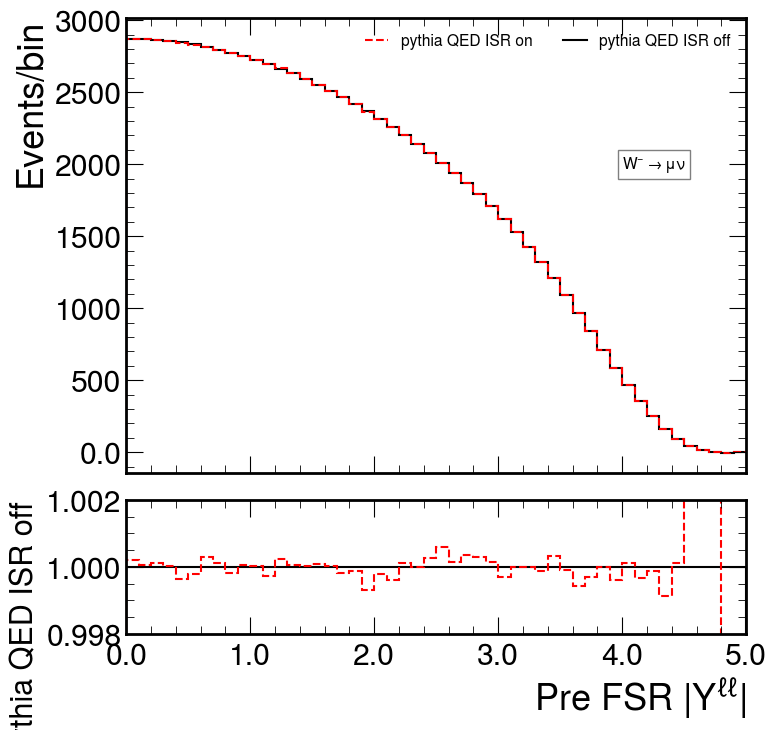

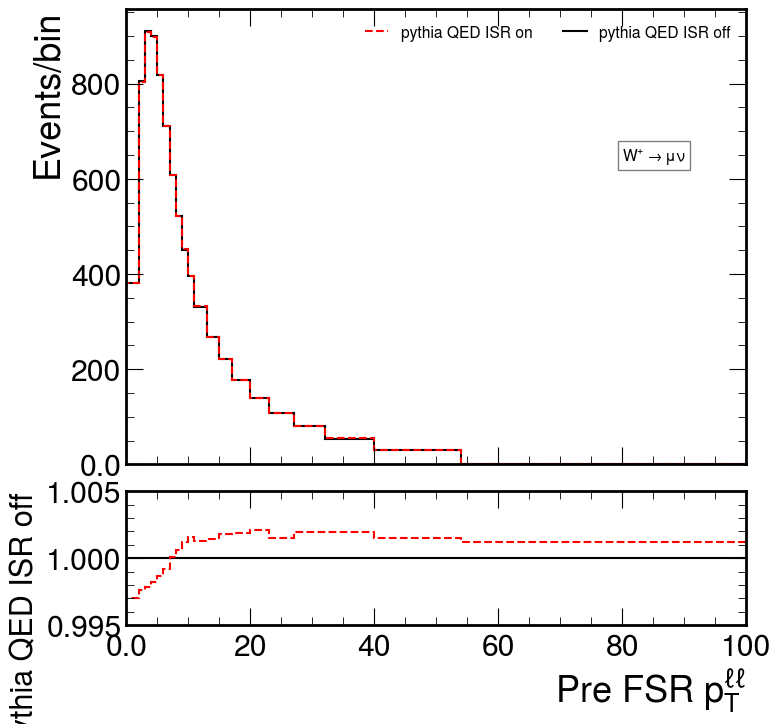

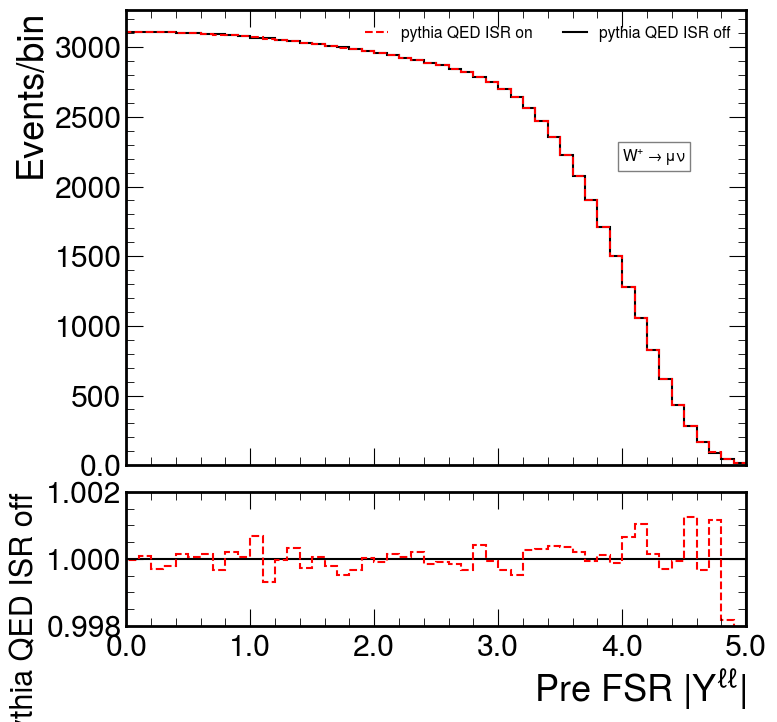

In [16]:
plot_corr("Z", "ptVgen", [f"{gen}ew_ISR"], f"{gen}ew_ISR", xlim=[0,100], rrange=[0.99,1.01])
plot_corr("Z", "absYVgen", [f"{gen}ew_ISR"], f"{gen}ew_ISR", xlim=[0,5], rrange=[0.998,1.002])
plot_corr("W", "ptVgen", [f"{gen}ew_ISR"], f"{gen}ew_ISR", xlim=[0,100], rrange=[0.995,1.005], selection={"charge":0})
plot_corr("W", "absYVgen", [f"{gen}ew_ISR"], f"{gen}ew_ISR", xlim=[0,5], rrange=[0.998,1.002], selection={"charge":0})
plot_corr("W", "ptVgen", [f"{gen}ew_ISR"], f"{gen}ew_ISR", xlim=[0,100], rrange=[0.995,1.005], selection={"charge":1})
plot_corr("W", "absYVgen", [f"{gen}ew_ISR"], f"{gen}ew_ISR", xlim=[0,5], rrange=[0.998,1.002], selection={"charge":1})

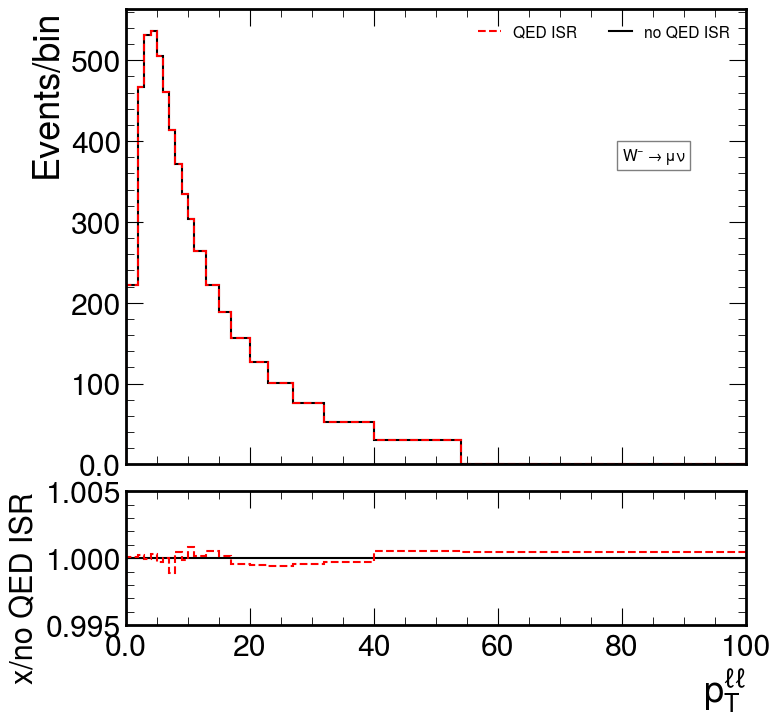

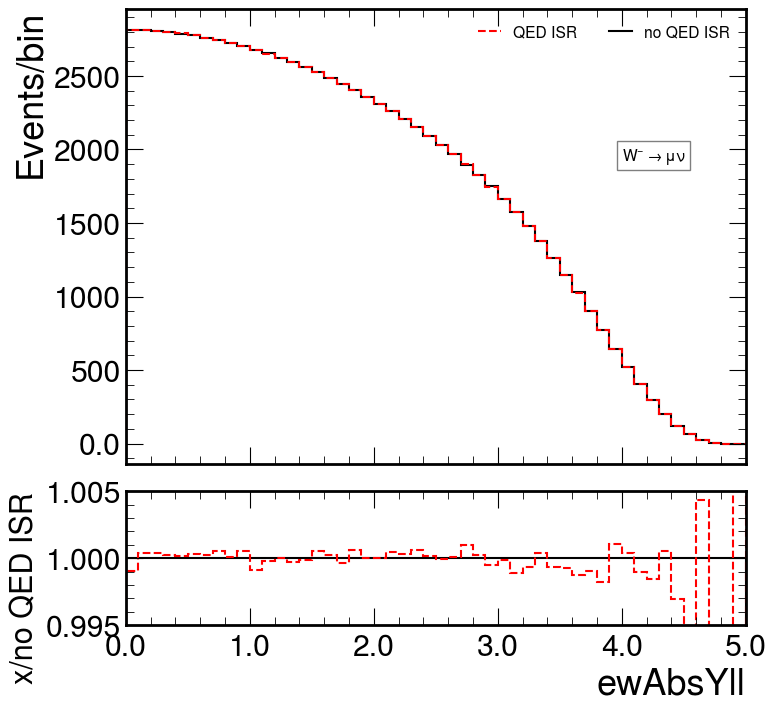

In [72]:
plot_corr("W", "ewPTll", ["MiNNLOew_ISR"], "MiNNLOew_ISR", selection={"charge":0}, xlim=[0,100], rrange=[0.995,1.005])
plot_corr("W", "ewAbsYll", ["MiNNLOew_ISR"], "MiNNLOew_ISR", selection={"charge":0}, xlim=[0,5], rrange=[0.995,1.005])

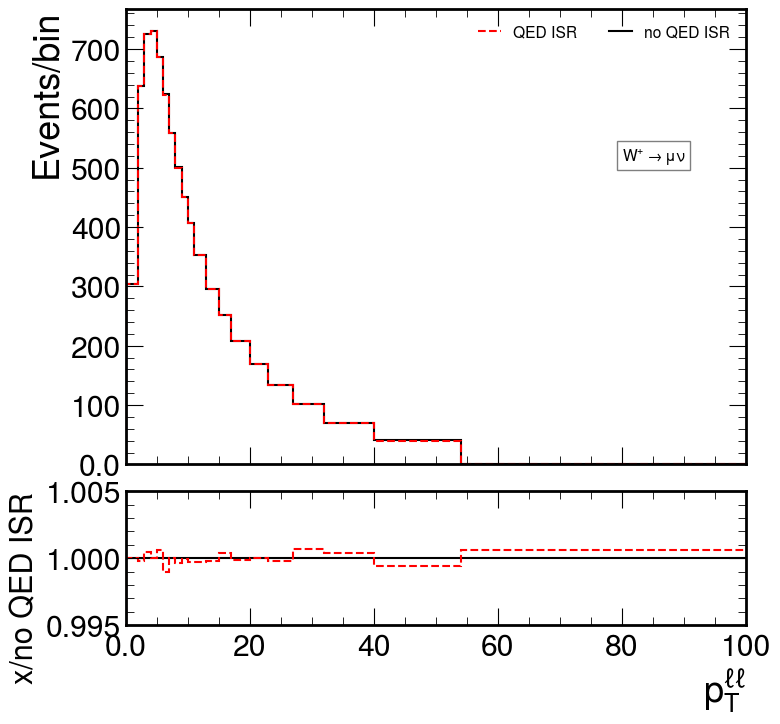

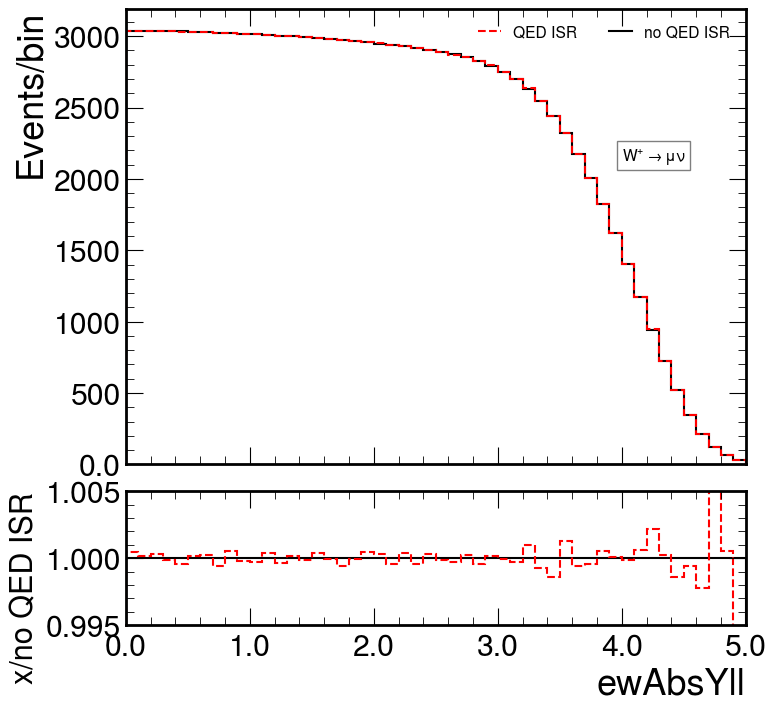

In [73]:
plot_corr("W", "ewPTll", ["MiNNLOew_ISR"], "MiNNLOew_ISR", selection={"charge":1}, xlim=[0,100], rrange=[0.995,1.005])
plot_corr("W", "ewAbsYll", ["MiNNLOew_ISR"], "MiNNLOew_ISR", selection={"charge":1}, xlim=[0,5], rrange=[0.995,1.005])

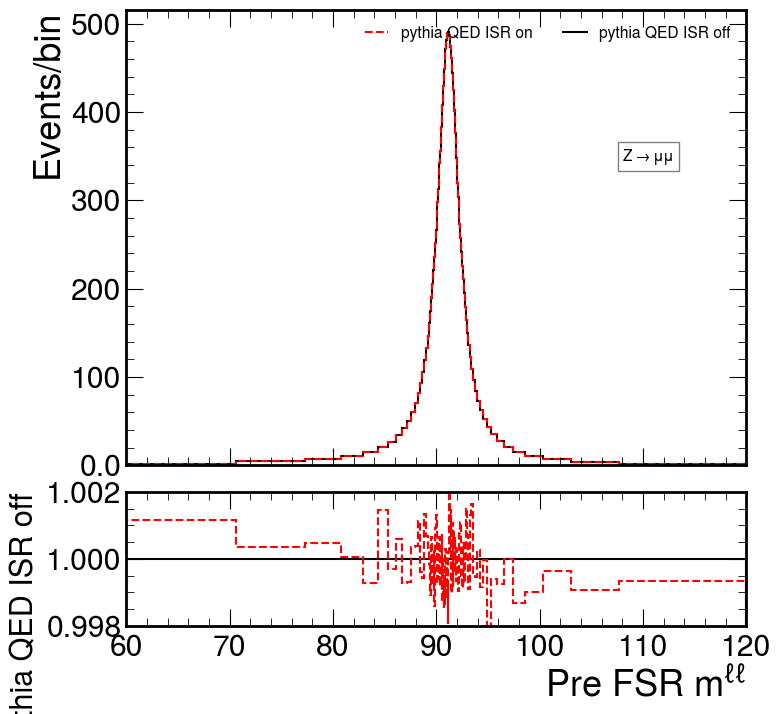

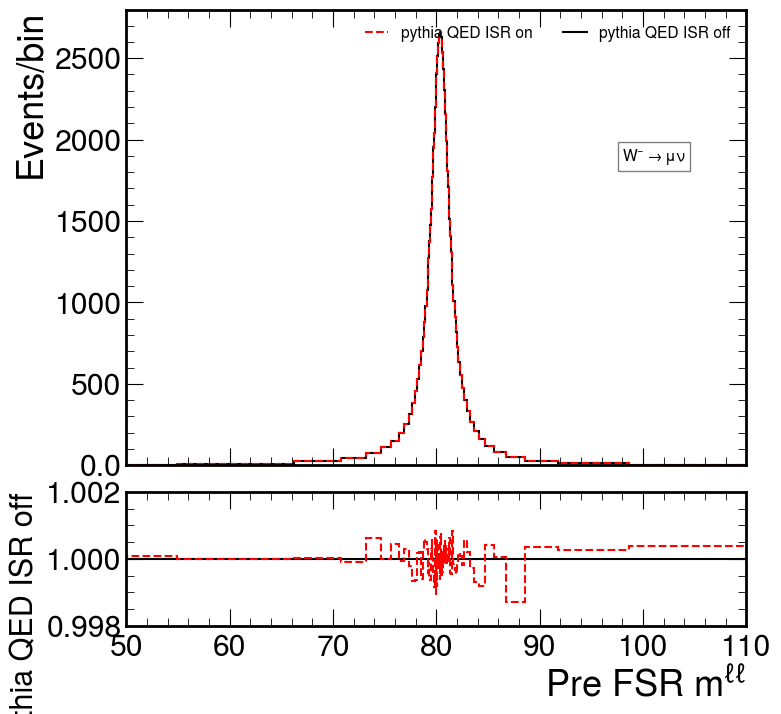

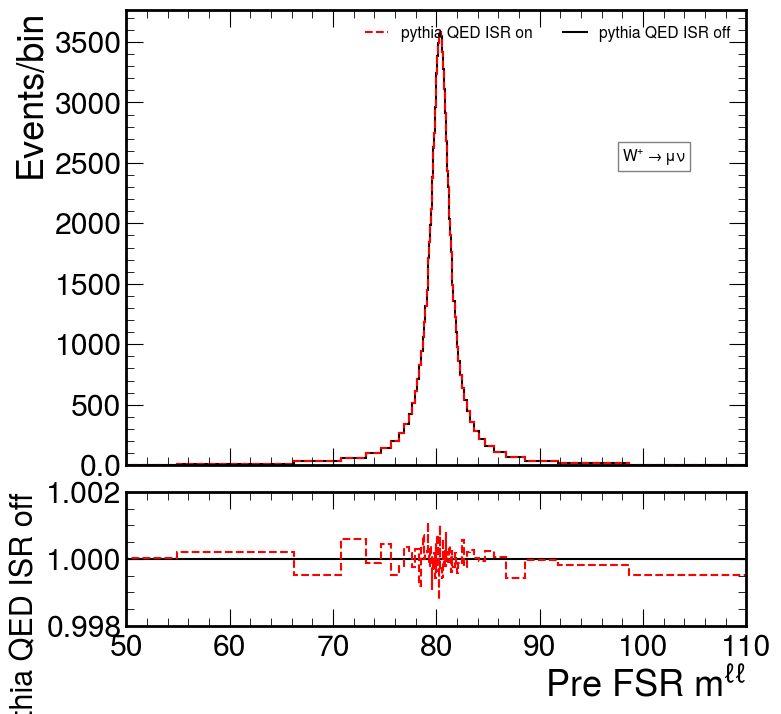

In [30]:
plot_corr("Z", "massVgen", [f"{gen}ew_ISR"], f"{gen}ew_ISR", xlim=[60,120], rrange=[0.998,1.002])
plot_corr("W", "massVgen", [f"{gen}ew_ISR"], f"{gen}ew_ISR", xlim=[50,110], rrange=[0.998,1.002], selection={"charge":0})
plot_corr("W", "massVgen", [f"{gen}ew_ISR"], f"{gen}ew_ISR", xlim=[50,110], rrange=[0.998,1.002], selection={"charge":1})

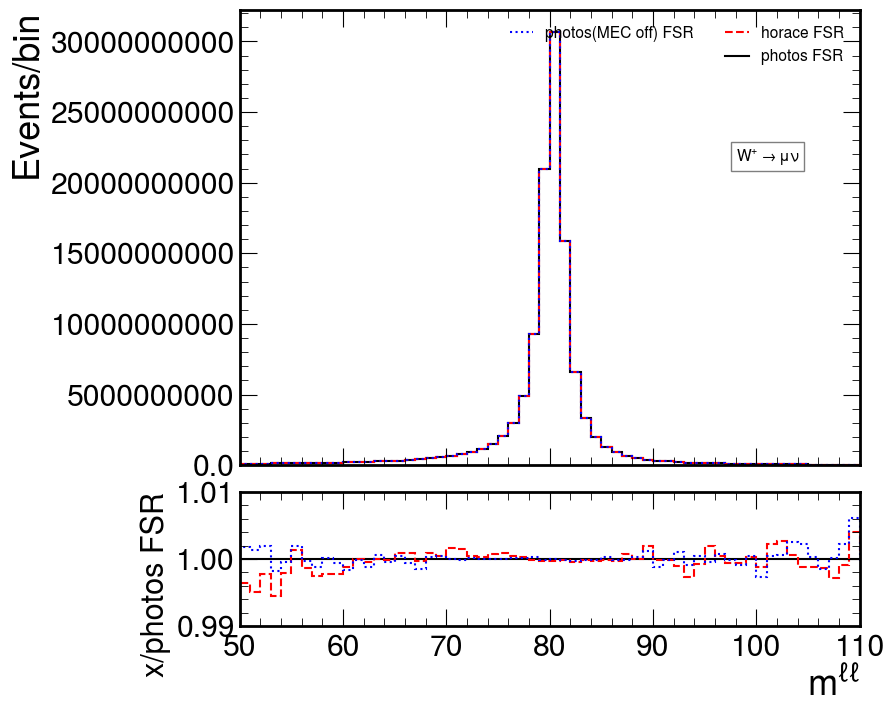

In [173]:
plot_corr("W", "Mll", ["horaceqedew", "horacelophotosmecoffew"], "horaceqedew", selection={"charge":1}, xlim=[50,110], rrange=[0.99,1.01])

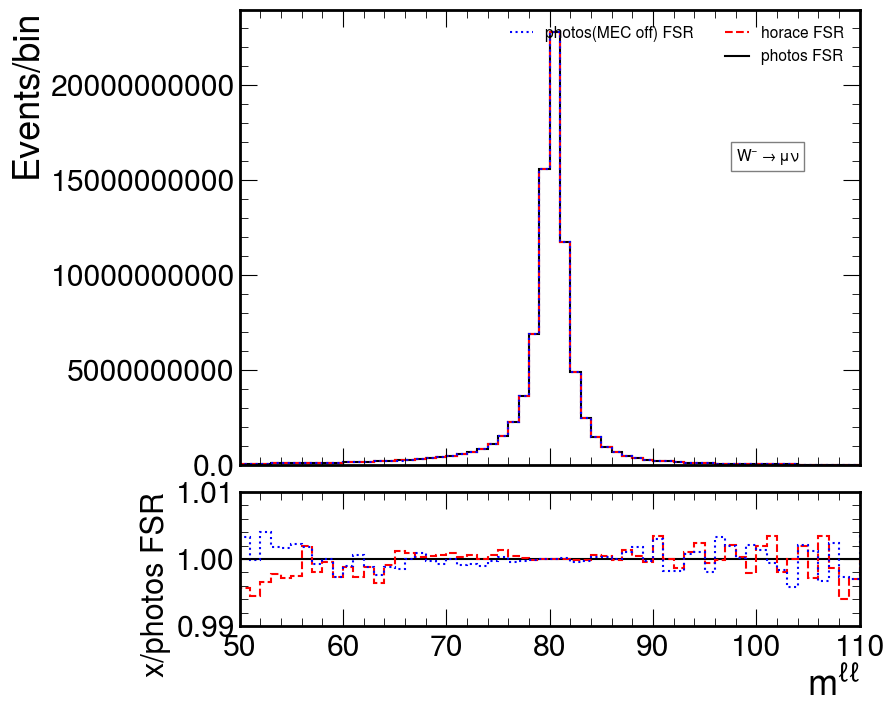

In [174]:
plot_corr("W", "Mll", ["horaceqedew", "horacelophotosmecoffew"], "horaceqedew", selection={"charge":0}, xlim=[50,110], rrange=[0.99,1.01])

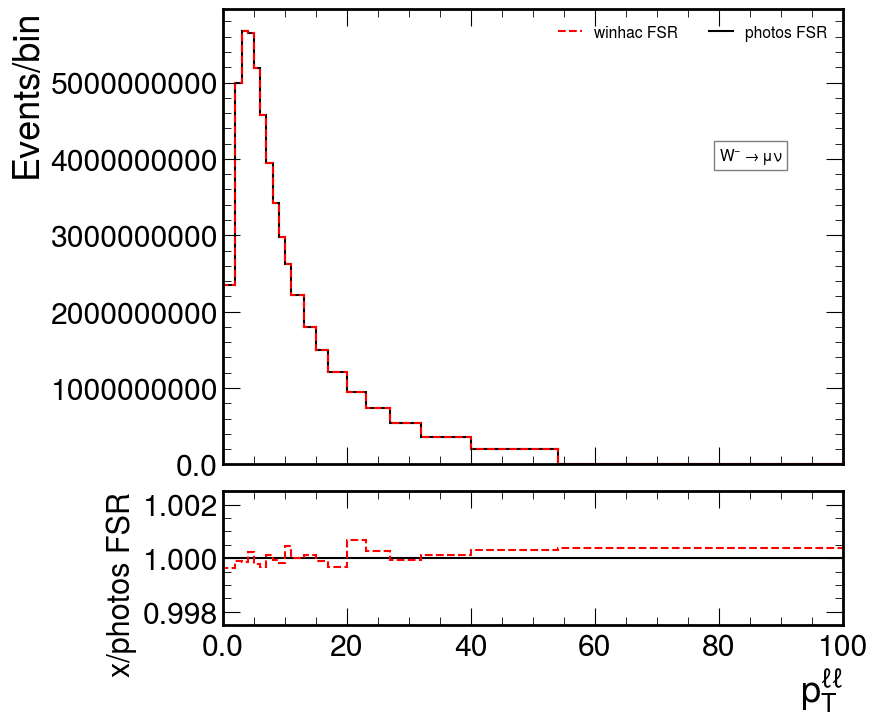

In [163]:
plot_corr("W", "ewPTll", ["winhacloew", ], "winhacloew", selection={"charge":0}, xlim=[0,100])

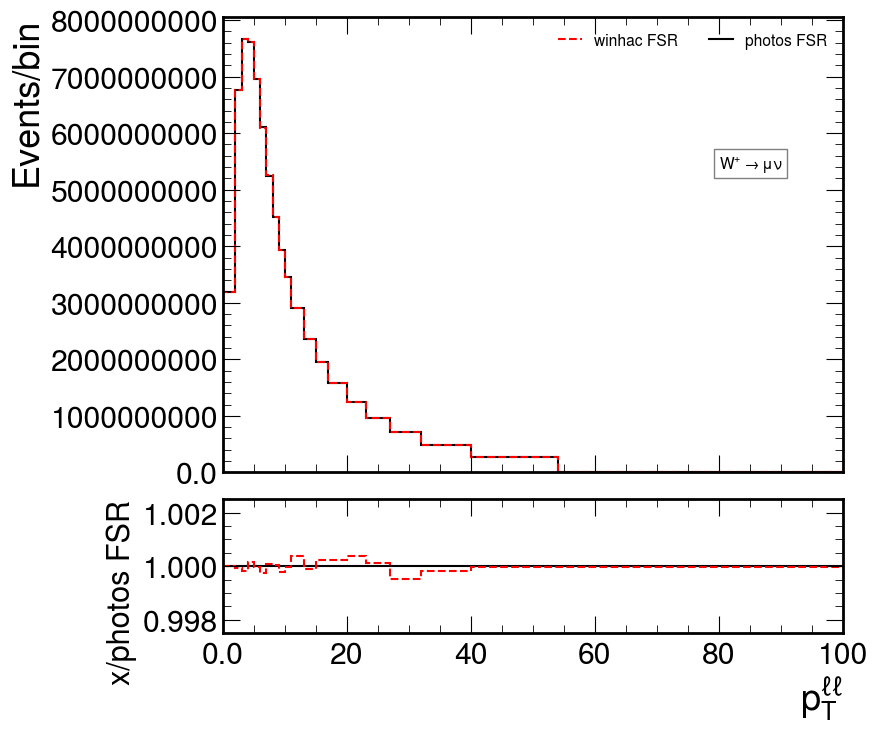

In [164]:
plot_corr("W", "ewPTll", ["winhacloew", ], "winhacloew", selection={"charge":1}, xlim=[0,100])

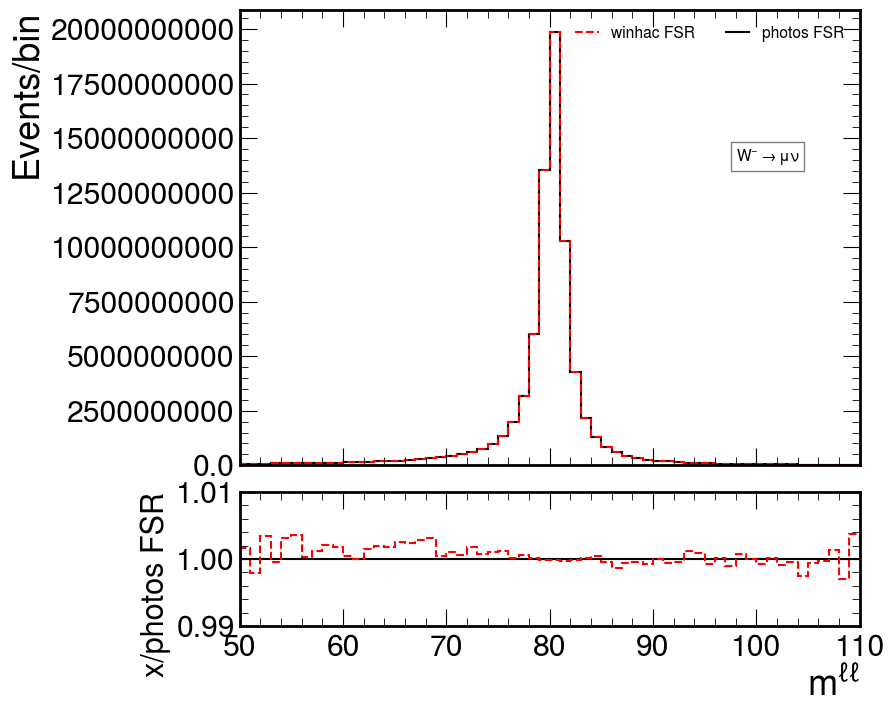

In [175]:
plot_corr("W", "Mll", ["winhacloew"], "winhacloew", selection={"charge":0}, xlim=[50,110], rrange=[0.99,1.01])

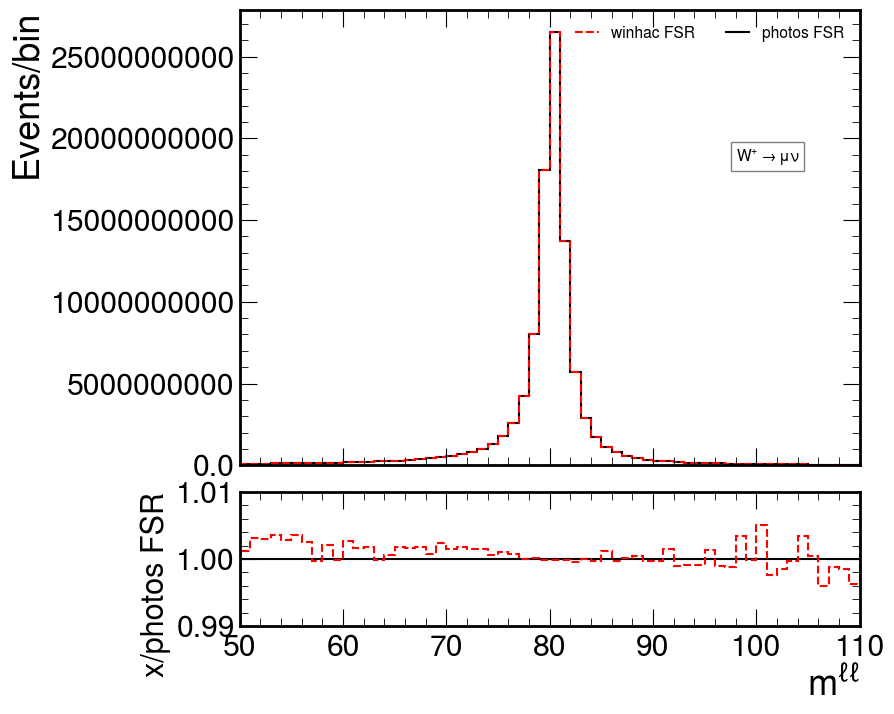

In [176]:
plot_corr("W", "Mll", ["winhacloew"], "winhacloew", selection={"charge":1}, xlim=[50,110], rrange=[0.99,1.01])

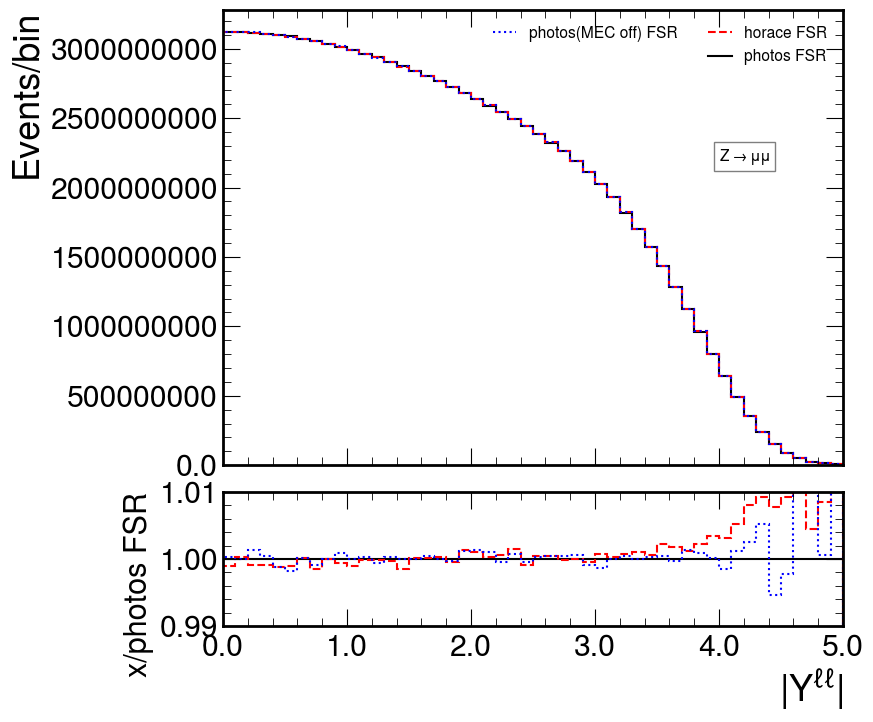

In [180]:
plot_corr("Z", "Yll", ["horaceqedew", "horacelophotosmecoffew"], "horaceqedew", xlim=[0,5], rrange=[0.99, 1.01])

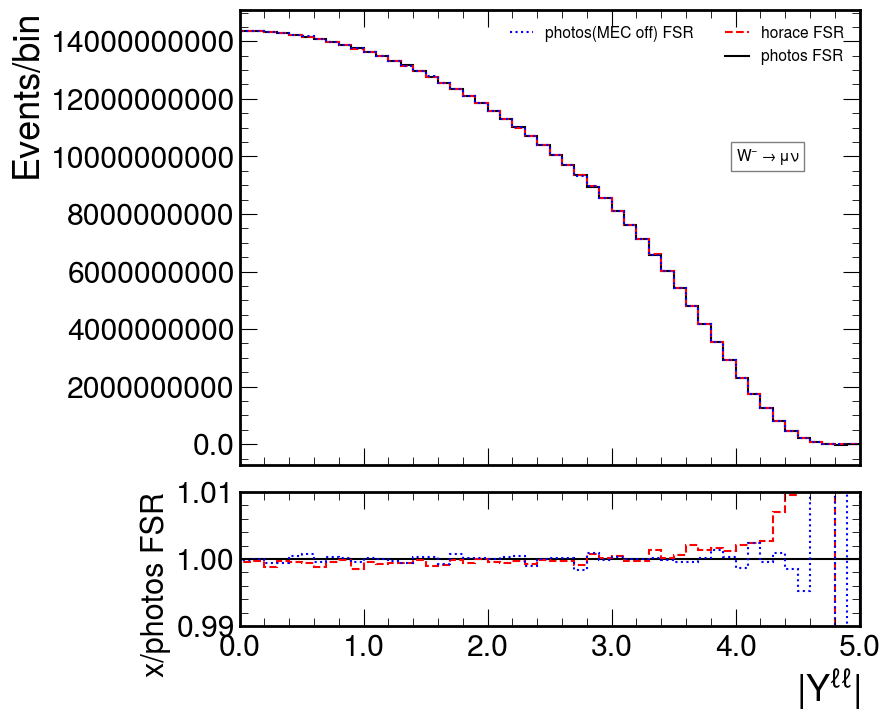

In [181]:
plot_corr("W", "Yll", ["horaceqedew", "horacelophotosmecoffew"], "horaceqedew", selection={"charge":0}, xlim=[0,5], rrange=[0.99, 1.01])

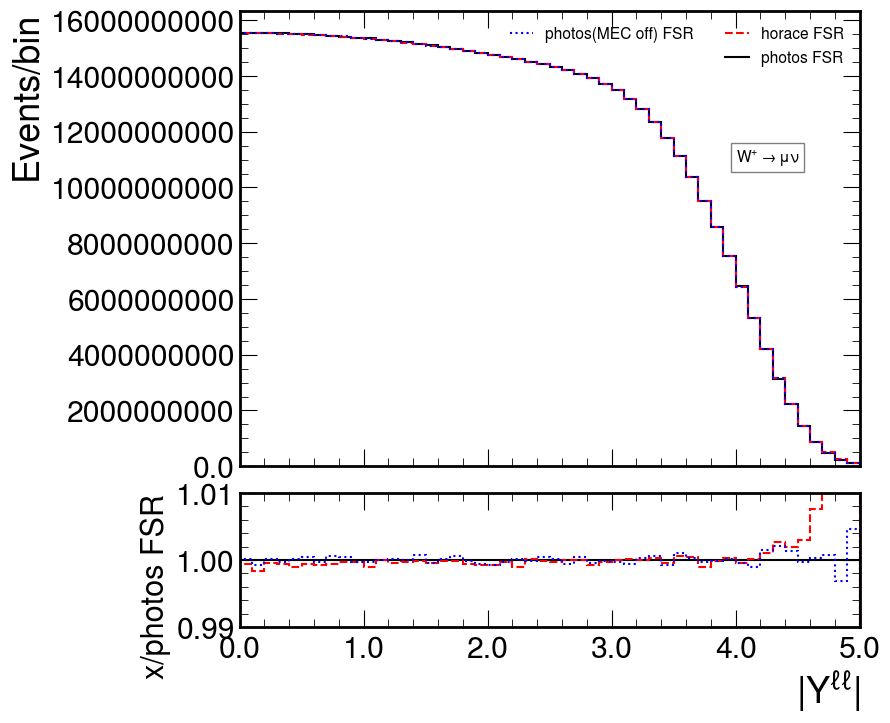

In [182]:
plot_corr("W", "Yll", ["horaceqedew", "horacelophotosmecoffew"], "horaceqedew", selection={"charge":1}, xlim=[0,5], rrange=[0.99, 1.01])

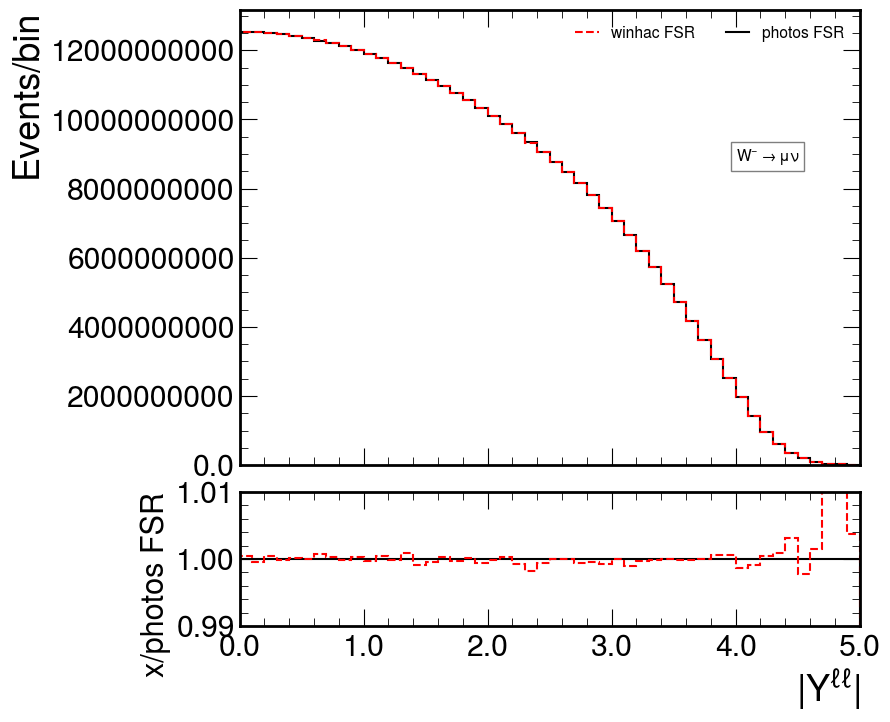

In [183]:
plot_corr("W", "Yll", ["winhacloew"], "winhacloew", selection={"charge":0}, xlim=[0,5], rrange=[0.99,1.01])

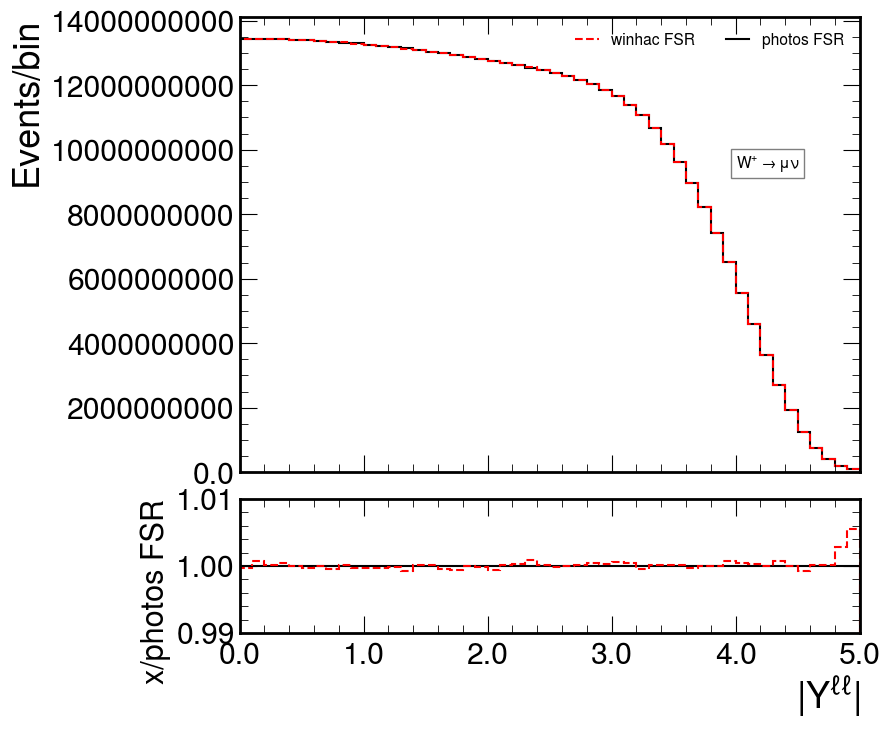

In [184]:
plot_corr("W", "Yll", ["winhacloew"], "winhacloew", selection={"charge":1}, xlim=[0,5], rrange=[0.99,1.01])

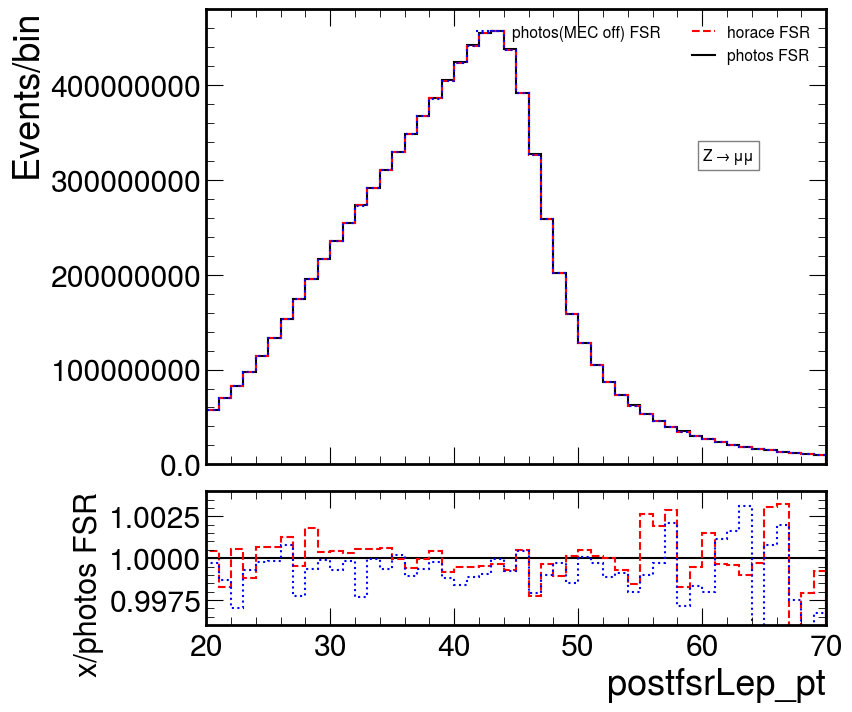

In [16]:
plot_corr("Z", "postfsrLep_pt", ["horaceqedew", "horacelophotosmecoffew"], "horaceqedew", xlim=[20,70])

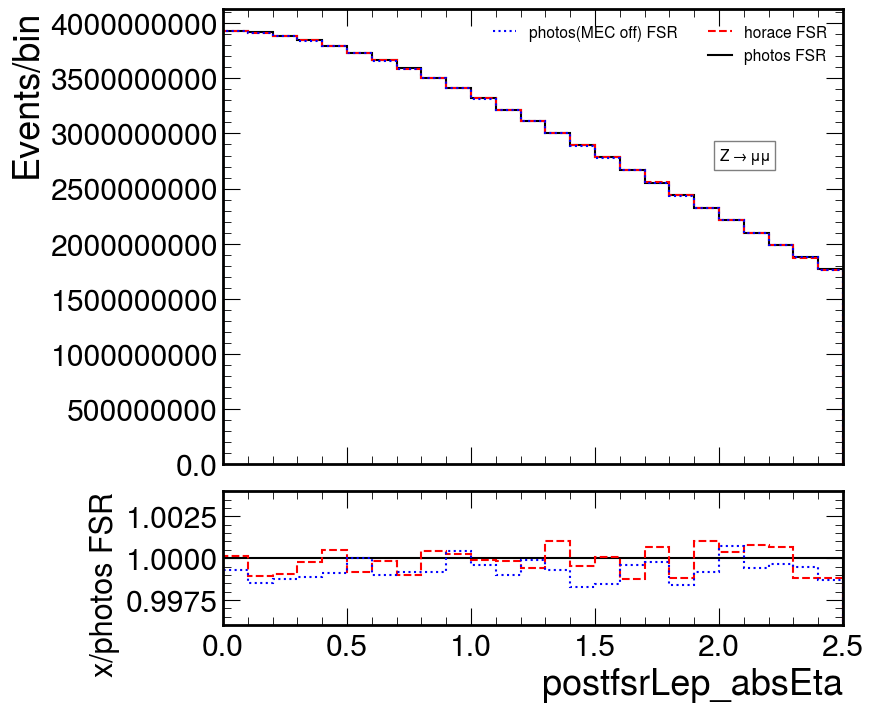

In [17]:
plot_corr("Z", "postfsrLep_absEta", ["horaceqedew", "horacelophotosmecoffew"], "horaceqedew", xlim=[0,2.5])

TypeError: '<' not supported between instances of 'list' and 'int'

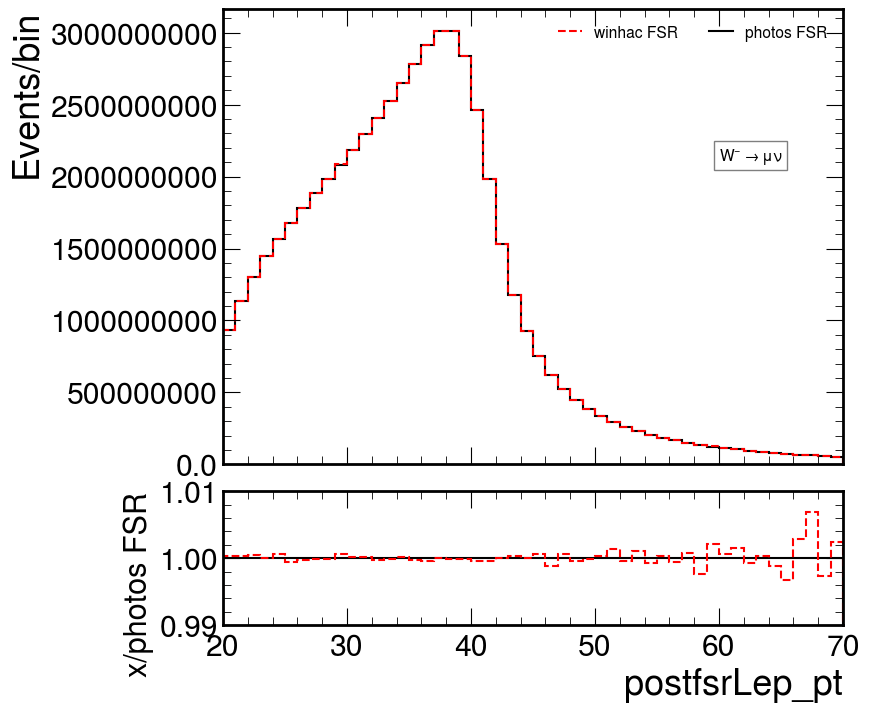

In [19]:
plot_corr("W", "postfsrLep_pt", ["winhacloew"], "winhacloew", selection={"charge":0}, xlim=[20,70], rrange=[0.99,1.01])

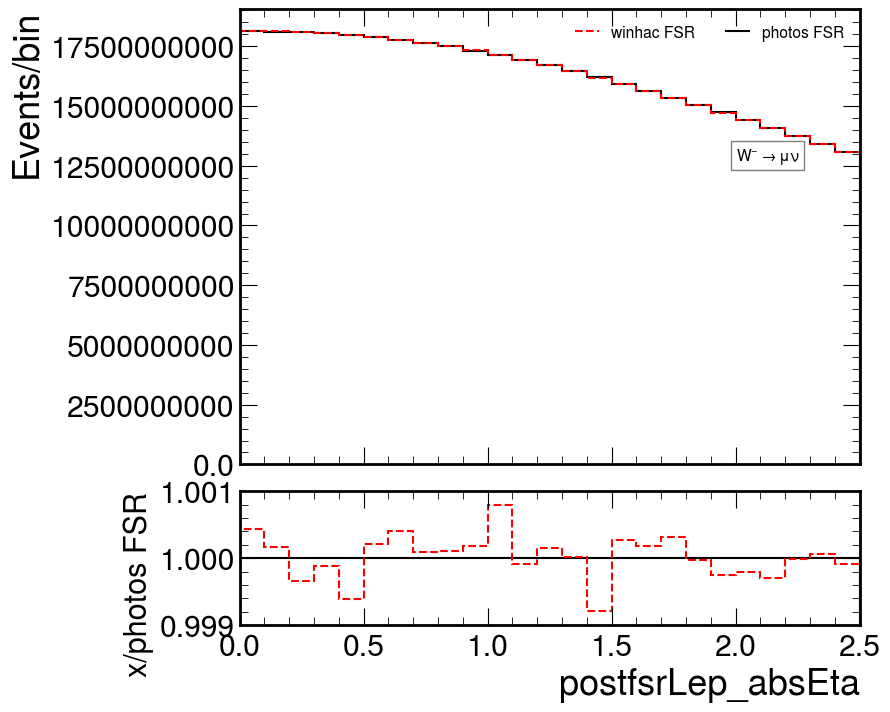

In [21]:
plot_corr("W", "postfsrLep_absEta", ["winhacloew"], "winhacloew", selection={"charge":0}, xlim=[0,2.5], rrange=[0.999,1.001])